## Оглавление

[1. Открытие файла с данными и изучение общей информации](#intro)

[2. Предобработка данных](#intro1)

  - [2.1 Стиль заголовков](#intro2)
  - [2.2 Замена типа данных](#intro3)
  - [2.3 Обработка дубликатов](#intro4)
  - [2.4 Проверка деления трафика](#intro5)

[3. Приоритизация гипотез](#intro6)

[4. Анализ A/B-теста](#intro7)

  - [4.1 Исследование кумулятивных метрик](#intro8)
  - [4.2 Анализ выбросов и всплесков](#intro9)
  - [4.3 Проверка данных на нормальность распределения](#intro10)
  - [4.4 Расчет статистической значимости в метриках между группами](#intro11)
  - [4.5 Решение по результатам теста](#intro12)

[5. Общий вывод](#intro13)


## Принятие решений в бизнесе

Я, как аналитик, вместе с отделом маркетинга крупного интернет-магазина подготовили список гипотез для увеличения выручки. 

### Задача.

Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

## 1. Открытие файла с данными и изучение общей информации               <a id='intro'></a>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as st
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
pd.set_option("max_colwidth", 110)

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')
except:
    hypothesis = pd.read_csv('hypothesis.csv', sep=',')

Выведем первые 5 строк датасета `hypothesis`

In [3]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Посмотрим общую информацию о данных в датасете `hypothesis`

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Посмотрим процент пропусков по столбцам.

In [5]:
round((hypothesis.isna().mean()*100),2)

Hypothesis    0.0
Reach         0.0
Impact        0.0
Confidence    0.0
Efforts       0.0
dtype: float64

В таблице 5 столбцов. Есть такие типы данных как: `int64` и `object`. Пропусков значений в столбцах нет.

Согласно документации к данным:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

В названиях колонок видно нарушение стиля: строчные буквы сочетаются с прописными.

In [6]:
try:
    orders = pd.read_csv('/datasets/orders.csv', sep=',')
except:
    orders = pd.read_csv('orders.csv', sep=',')

Выведем первые 5 строк датасета `orders`

In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Посмотрим общую информацию о данных в датасете `orders`

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Посмотрим процент пропусков по столбцам.

In [9]:
round((orders.isna().mean()*100),2)

transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

В таблице 5 столбцов. Есть такие типы данных как: `int64` и `object`. Пропусков значений в столбцах нет.

Согласно документации к данным:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

В названиях колонок видны три нарушения стиля:
1. Строчные буквы сочетаются с прописными;
2. В названиях примененен стиль CamelCase('верблюжийРегистр')

In [10]:
try:
    visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
except:
    visitors = pd.read_csv('visitors.csv', sep=',')

Выведем первые 5 строк датасета `visitors`

In [11]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Посмотрим общую информацию о данных в датасете `visitors`

In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Посмотрим процент пропусков по столбцам.

In [13]:
round((visitors.isna().mean()*100),2)

date        0.0
group       0.0
visitors    0.0
dtype: float64

В таблице 3 столбца. Есть такие типы данных как: `int64` и `object`. Пропусков значений в столбцах нет.

Согласно документации к данным:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

### Вывод

Для исследования доступны 3 таблицы. 

Пропусков в датасетах не обнаружено, в названиях колонок двух таблиц имеются нарушения стиля, предварительно можно утверждать, что данных достаточно для нашего исследования.

## 2. Предобработка данных                                                                <a id='intro1'></a>   

### 2.1 Стиль заголовков                                                                                                       <a id='intro2'></a>

Приведем названия столбцов в датасетах `hypothesis`, `orders` в соответствие с хорошим стилем с помощью методов `set_axis` и `str.lower`:
* несколько слов в названии запишем в «змеином_регистре»,
* все символы сделаем строчными

In [14]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [15]:
orders.set_axis(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], axis='columns', inplace=True)
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

### 2.2 Замена типа данных                                                                                                        <a id='intro3'></a>

In [16]:
for data, df in [('orders', orders), ('visitors',visitors)]:
    df['date'] = pd.to_datetime(df['date'])
    print(f'Тип данных столбцов в датасете {data}')
    print(df.dtypes)
    print()

Тип данных столбцов в датасете orders
transaction_id             int64
visitor_id                 int64
date              datetime64[ns]
revenue                    int64
group                     object
dtype: object

Тип данных столбцов в датасете visitors
date        datetime64[ns]
group               object
visitors             int64
dtype: object



### 2.3 Обработка дубликатов                                                                            <a id='intro4'></a>

Подсчитаем количество строк-дубликатов датасета `hypothesis`. 

In [17]:
hypothesis.duplicated().sum()

0

Подсчитаем количество строк-дубликатов датасета `orders`. 

In [18]:
orders.duplicated().sum()

0

Подсчитаем количество строк-дубликатов датасета `visitors`.

In [19]:
visitors.duplicated().sum()

0

### 2.4 Проверка деления трафика                                                                            <a id='intro5'></a>

Проверим качество деления трафика. Для успешного проведения A/B-теста количество пользователей в различных группах не должно превышать 1% и в группах не должно быть пересечения пользователей.

Посмотрим различается ли количество пользователей в группах теста.

In [20]:
diff_users = orders.groupby('group', as_index=False).agg({'visitor_id': 'nunique'})
diff_users

,group,visitor_id
0,A,503
1,B,586


In [21]:
print('Разница в группах по пользователям: {:%}'.format(diff_users.visitor_id[1] / diff_users.visitor_id[0] - 1))

Разница в группах по пользователям: 16.500994%


Проверим группы на пересекающихся пользователей. Воспользуемся методом `np.intersect1d`, который найдет пересечение в `Series`.

In [22]:
pd.Series(np.intersect1d(orders[orders['group'] == 'A']['visitor_id'],\
                               orders[orders['group'] == 'B']['visitor_id'])).count()

58

Анализ показал что количество пользователей различается на 16.5%, в группах 58 пересекающихся пользователей. Можно было бы удалить пересекающихся пользователей из обоих групп, но в датасете `visitors` это сделать не получится, так в данных указано только количество пользователей по группам и пересекающихся пользователей мы найти и удалить там не сможем.
Оставим данные без изменений. Будем учитывать что к результатам теста стоит относится с осторожностью.

**Вывод**

Для расчетов в наших исследованиях мы изменили тип данных в некоторых столбцах.  
Предобработка не обнаружила дубликаты. Обнаружено некорректное разделение трафика по группам.

## 3. Приоритизация гипотез.                                                                   <a id='intro6'></a>

Еще раз посмотрим на данные в датасете `hypothesis`

In [23]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Применим фреймворк `ICE` к датасету `hypothesis` для приоритизации гипотез. Отсортируем их по убыванию приоритета.  
Будем использовать следующую формулу для расчета:

$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [24]:
hypothesis['ice'] = (hypothesis.impact * hypothesis.confidence) / hypothesis.efforts
print(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

Наиболее перспективные гипотезы по `ICE` - 8, 0, 7.

Применим фреймворк `RICE` для приоритизации гипотез. Отсортируем их по убыванию приоритета. Применим стили для визуализации.  
Здесь будем использовать такую формулу:

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [25]:
hypothesis['rice'] = (hypothesis.reach * hypothesis.impact * hypothesis.confidence) / hypothesis.efforts

In [26]:
hypothesis[['hypothesis', 'ice', 'rice']].sort_values(by='rice', ascending=False)
cm = sns.light_palette("green", as_cmap=True)

hypothesis[['hypothesis', 'ice', 'rice']].sort_values(by='rice', ascending=False).style.background_gradient(cmap=cm)

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


По `RICE` Наиболее перспективные гипотезы изменились. Теперь это: 7, 2, 0, 6. Это произошло из за параметра `reach` - охвата пользователей. Он наиболее высокий у гипотезы под номером 7 и теперь она заняла первое место. Гипотеза 8 опустилась в середину списка из за очень низкого охвата пользователей.

### Вывод

Приоритизация гипотез с помощью фреймворков `ICE` и `RICE` показала что кроме силы гипотез необходимо учитывать и охват пользователей, которых захватывают эти гипотезы.

## 4. Анализ A/B-теста.                                                                               <a id='intro7'></a>

### 4.1 Исследование кумулятивных метрик.                                                                   <a id='intro8'></a>

Чтобы построить необходимые нам графики в исследовании, нужно собрать кумулятивные данные. Объявим датафрейм `cumulativeData` со столбцами:
- `date` — дата;
- `group` — группа A/B-теста (A или B);
- `orders` — кумулятивное количество заказов на указанную дату в указанной группе;
- `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- `visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Создадим массив уникальных пар значений дат и групп теста , используем метод `drop_duplicates()`:

In [27]:
datesGroups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах.  
Получим строки таблицы `orders`, дата которых меньше или равна дате элемента из `datesGroups`, а группа теста равна группе из `datesGroups`.  
Агрегируем значения. Вычислим максимальную дату, максимум группы, число уникальных `id` заказов и пользователей, сумму средних чеков.

In [28]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [29]:
ordersAggregated = datesGroups.\
    apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].\
    agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'revenue' : 'sum'}), axis=1).\
    sort_values(by=['date','group']) 

In [30]:
ordersAggregated.head()

,date,group,transaction_id,revenue
55,2019-08-01,A,24,148579
66,2019-08-01,B,21,101217
175,2019-08-02,A,44,242401
173,2019-08-02,B,45,266748
291,2019-08-03,A,68,354874


Получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [31]:
visitorsAggregated = datesGroups.\
    apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].\
    agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [32]:
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим кумулятивные данные в одной таблице с помощью `merge()`, поменяем названия столбцов.

In [33]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, on=(['date', 'group']))
cumulativeData.columns = ['date', 'group', 'orders', 'revenue', 'visitors']


In [34]:
cumulativeData.head()

,date,group,orders,revenue,visitors
0,2019-08-01,A,24,148579,719
1,2019-08-01,B,21,101217,713
2,2019-08-02,A,44,242401,1338
3,2019-08-02,B,45,266748,1294
4,2019-08-03,A,68,354874,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

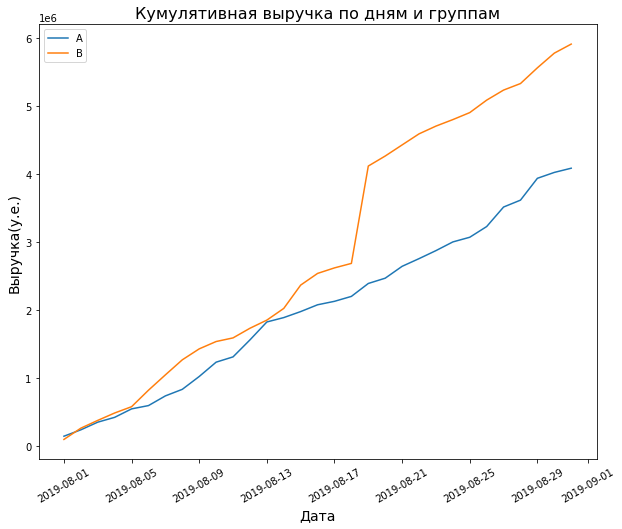

In [35]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
# Строим график выручки группы А
plt.figure(figsize=(10,8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по дням и группам', fontsize=16)
plt.xlabel('Дата', fontsize=14)   
plt.ylabel('Выручка(у.е.)', fontsize=14)
plt.xticks(rotation=30)
plt.legend();


Выручка группы А почти равномерно увеличивается в течение всего теста. В середине теста сегмент В вырвался вперед и продолжал лидировать до конца теста. Видимо здесь присутствует влияние аномально больших заказов. С такими заказами будем разбираться далее.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

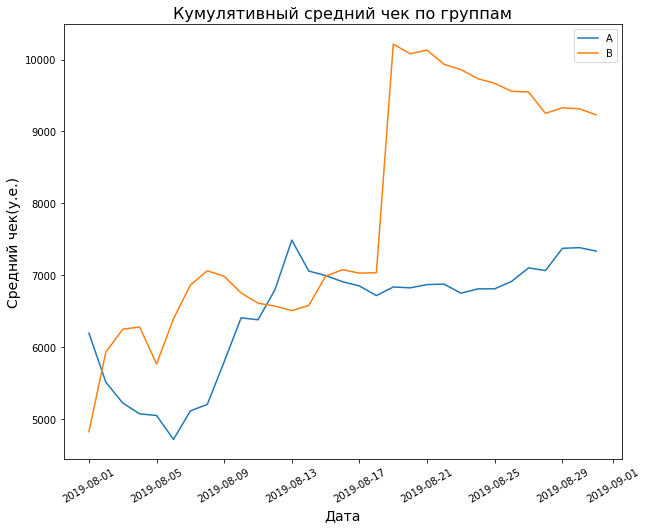

In [36]:
plt.figure(figsize=(10,8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам', fontsize=16)
plt.xlabel('Дата', fontsize=14)   
plt.ylabel('Средний чек(у.е.)', fontsize=14)
plt.xticks(rotation=30)
plt.legend();


Кумулятивное значение среднего чека по группам колеблется на всем протяжении теста. Скорее всего принимать решение по этой метрике рано. Возможно, стоит провести дополнительный анализ выбросов, которые воздействуют на результаты. 

Теперь расчитаем относительное изменение кумулятивного среднего чека группы B к группе A

Собираем данные в одном датафрейме.

In [37]:
mergedCumulativeRevenue = cumulativeRevenueA.\
    merge(cumulativeRevenueB, on='date', how='left', suffixes=['A', 'B'])

In [38]:
mergedCumulativeRevenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


Построим график отношения средних чеков в группах. Добавим горизонтальную ось методом `axhline()`

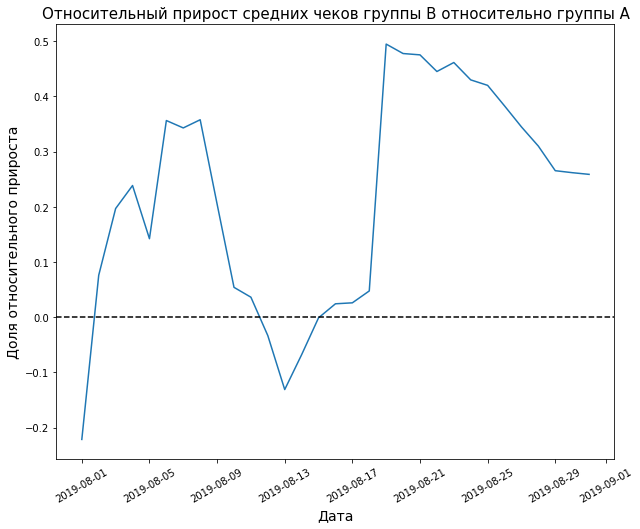

In [39]:
plt.figure(figsize=(10,8))
plt.plot(mergedCumulativeRevenue['date'], \
    ((mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
     (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1))
plt.title('Относительный прирост средних чеков группы B относительно группы A', fontsize=15)
plt.xlabel('Дата', fontsize=14)   
plt.ylabel('Доля относительного прироста', fontsize=14)
plt.xticks(rotation=30)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

В некоторых точках видим резкое изменение результатов теста. Видимо в эти даты были совершены аномальные заказы.

Высчитаем кумулятивную конверсию.

In [40]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

Выделим данные по группе A.

In [41]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

Выделим данные по группе B.

In [42]:
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

Построим график кумулятивной конверсии по группам. Зададим масштаб осей методом `plt.axis()`. Передадим ему минимальное и максимальное значения оси x; минимальное и максимальное значения оси y — ['2019-08-01', '2019-09-01', 0, 0.05]:


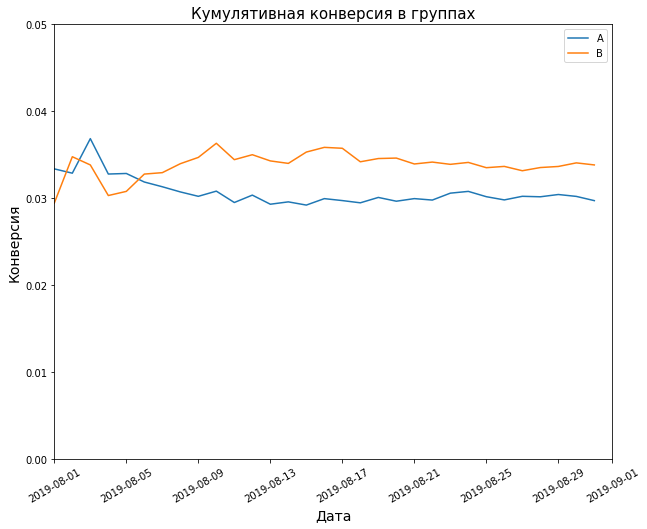

In [43]:
plt.figure(figsize=(10,8))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивная конверсия в группах', fontsize=15)
plt.xlabel('Дата', fontsize=14)   
plt.ylabel('Конверсия', fontsize=14)
plt.legend()
plt.xticks(rotation=30)
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05]);


В начале теста наблюдаются колебания в двух группах, конверсия группы A немного выше группы B. Затем конверсии достаточно быстро выравниваются, конверсия группы B превышает конверсию в группе A.  

Посчитаем относительное изменения кумулятивной конверсии группы B к группе A.

Собираем данные в одном датафрейме.

In [44]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].\
    merge(cumulativeDataB[['date','conversion']], on='date', how='left', suffixes=['A', 'B'])

In [45]:
mergedCumulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


Построим график изменения кумулятивной конверсии в группах. Добавим горизонтальную ось методом `axhline()`

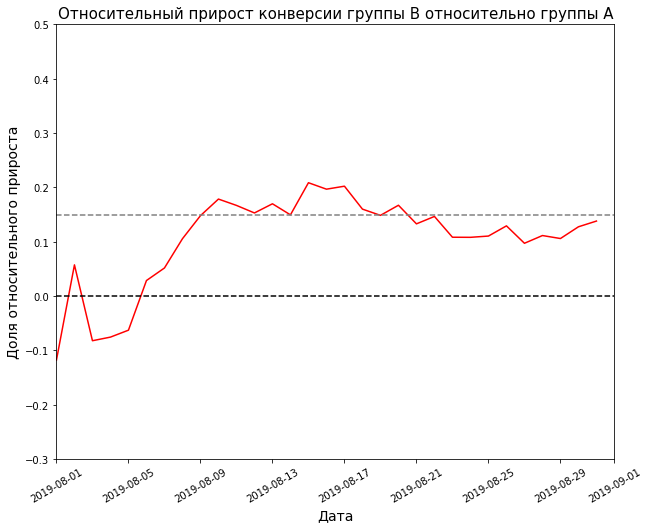

In [46]:
plt.figure(figsize=(10,8))
plt.plot(mergedCumulativeConversions['date'], \
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, color='r')
plt.title('Относительный прирост конверсии группы B относительно группы A', fontsize=15)
plt.xlabel('Дата', fontsize=14)   
plt.ylabel('Доля относительного прироста', fontsize=14)
plt.xticks(rotation=30)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.3, 0.5]);

Почти с самого начала теста видим лидерство группы B по конверсии. Конверсия группы B в начале теста растет и формируется около прироста в 15% относительно группы A.

### 4.2 Анализ выбросов и всплесков.                                                                                  <a id='intro9'></a>

В данных могут присутствовать аномалии, которые могут искажать результаты A/B-теста.

Построим распределения стоимостей заказов c помощью графика `scatter`.

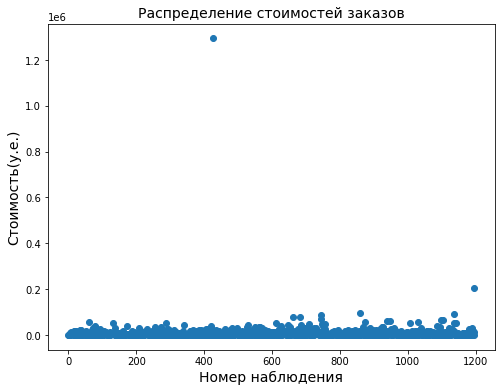

In [47]:
plt.figure(figsize=(8,6))
x_values = pd.Series(range(0,len(orders['revenue']))) # задаем по оси X номера наблюдений
plt.scatter(x_values, orders['revenue']) 
plt.title('Распределение стоимостей заказов', fontsize=14) 
plt.xlabel('Номер наблюдения', fontsize=14)   
plt.ylabel('Стоимость(у.е.)', fontsize=14);


На графике видим что в датасете есть два дорогих заказа, один из них очень сильно выбивается по цене. Заказов стоимостью выше 50 000 совсем мало. Это число можно выбрать границей аномальных заказов. Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями.


Определим 90, 95 и 99 перцентили стоимости заказа в выборке.

In [48]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


Не более 5% заказов дороже 28 000 и не более 1% дороже 58233.

Помимо стоимости заказа проанализируем конверсию. Она равна отношению числа заказов к количеству посетителей сайта за время теста.
Пользователи, совершившие много заказов, влияют на числитель формулы конверсии. Поведение таких пользователей скорее всего отличается от нормального. Если речь не идёт об интернет-магазине с регулярным спросом, «обычный» пользователь совершает не больше двух заказов за короткий срок.

Подсчитаем количество заказов по пользователям


In [49]:
ordersByUsers = orders.groupby('visitor_id', as_index=False).\
    agg({'transaction_id': 'nunique'})

 
ordersByUsers.columns = ['visitor_id', 'transactions']
 
print(ordersByUsers.sort_values(by='transactions', ascending=False).head(10)) 


      visitor_id  transactions
1023  4256040402            11
591   2458001652            11
569   2378935119             9
487   2038680547             8
44     199603092             5
744   3062433592             5
55     237748145             5
917   3803269165             5
299   1230306981             5
897   3717692402             5


Есть пользователи, которые совершали 5, 8, 9, и 11 заказов. Значительно больше, чем обычный пользователь за неделю.

Построим точечную диаграмму числа заказов на одного пользователя.

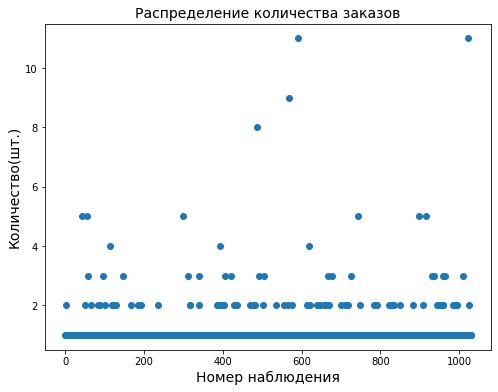

In [50]:
plt.figure(figsize=(8,6))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['transactions'])
plt.title('Распределение количества заказов', fontsize=14) 
plt.xlabel('Номер наблюдения', fontsize=14)   
plt.ylabel('Количество(шт.)', fontsize=14);

На графике видим, что много пользователей с 2-3 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.


Посчитаем выборочные перцентили количества заказов на одного пользователя

In [51]:
print(np.percentile(ordersByUsers['transactions'], [90, 95, 99])) 

[1. 2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа. И 10% пользователей заказывали более одного раза.
Стоит выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

### 4.3 Проверка данных на нормальность распределения                                     <a id='intro10'></a>

Перед расчетом статистической значимости между группами, проверим данные на нормальность распределения с помощью критерия Шапиро-Уилка.

Подготовим данные.

In [52]:
# переменная с количеством пользователей в выбранную дату в группе A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
# переменная с количеством пользователей до выбранной даты включительно в группе A 
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
{'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
# переменная с количеством пользователей в выбранную дату в группе B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
 # переменная с количеством пользователей до выбранной даты включительно в группе B
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateB': 'sum'}),axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
# переменная с количеством заказов и суммарной стоимостью заказов в выбранную дату в группе A
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
# переменная с суммарным числом заказов и суммарной выручкой до выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}),axis=1).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA']
# переменная с количеством заказов и суммарной стоимостью заказов в выбранную дату в группе B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
# переменная с суммарным числом заказов и суммарной выручкой до выбранной даты включительно в группе B
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}),axis=1).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB']
# соберем все данные в одной таблице 
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))


In [53]:
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Создадим переменные `ordersByUsersA` и `ordersByUsersB` со столбцами ['visitor_id', 'transactions']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [54]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'}))
ordersByUsersA.columns = ['visitor_id', 'orders']
 
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsersB.columns = ['visitor_id', 'orders']


Объявим переменные `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.
Применим методы `np.arange()` и `pd.concate()`

In [55]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].\
    sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
 
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].\
    sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Проверим методом `st.shapiro(x)`, можно ли считать эти переменные нормально распределёнными

In [56]:
alpha = 0.05  # критический уровень статистической значимости
results = st.shapiro(sampleA)
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 


p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


In [57]:
alpha = 0.05  # критический уровень статистической значимости
results = st.shapiro(sampleB)
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 


p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Метод Шапиро-Уилка показал что переменные с количеством заказов распределены не нормально. Значит для расчета статистической значимости между группами стоит использовать тест Манна-Уитни, который устойчив к аномалиям.

Проверим распределение средних чеков в группах.

In [58]:
alpha = 0.05  # критический уровень статистической значимости
results = st.shapiro(orders[orders['group']=='A']['revenue'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  1.739703399801917e-34
Отвергаем нулевую гипотезу: распределение не нормально


In [59]:
alpha = 0.05  # критический уровень статистической значимости
results = st.shapiro(orders[orders['group']=='B']['revenue'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Здесь также в расчете статистической значимости выручек между группами стоит использовать тест Манна-Уитни.

Ранее мы вычислили, что 95-й и 99-й перцентили средних чеков равны 28000 и 58233. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 30 000. Так мы уберём от 1% до 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 3 — `usersWithManyOrders` и пользователей, совершивших заказы дороже 30 000 — `usersWithExpensiveOrders`. Объединим их в таблице `abnormalUsers`.

Узнаем, сколько всего аномальных пользователей методом `shape()`.

In [60]:
usersWithManyOrders = pd.concat([
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitor_id']],axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).\
    drop_duplicates().sort_values()

print(abnormalUsers.head())
print(abnormalUsers.shape)

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitor_id, dtype: int64
(57,)


Всего 57 аномальных пользователей.
Подготовим выборки количества заказов по пользователям по группам теста с отфтльтрованными данными:


In [61]:
sampleAFiltered = (pd.concat([ordersByUsersA[
        np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0))
 
sampleBFiltered = (pd.concat([ordersByUsersB[
        np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)) 



Проверим методом `st.shapiro(x)`, можно ли считать эти переменные нормально распределёнными

In [62]:
alpha = 0.05  # критический уровень статистической значимости
results = st.shapiro(sampleAFiltered)
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


In [63]:
alpha = 0.05  # критический уровень статистической значимости
results = st.shapiro(sampleBFiltered)
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Здесь также распределения не нормальны. В расчетах статистической значимости будем использовать тест Манна-Уитни.

Посмотрим распределение средних чеков в группах.

In [64]:
alpha = 0.05  # критический уровень статистической значимости
results = st.shapiro(orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  1.8868852738833219e-25
Отвергаем нулевую гипотезу: распределение не нормально


In [65]:
alpha = 0.05  # критический уровень статистической значимости
results = st.shapiro(orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  5.261565978280583e-28
Отвергаем нулевую гипотезу: распределение не нормально


Здесь как и везде видим, что для расчета статистической значимости стоит использовать тест Манна-Уитни. 

### 4.4 Расчет статистической значимости в метриках между группами                                     <a id='intro11'></a>

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей — найдём среднее в выборке `sampleA` методом `mean()`. Аналогично найдём конверсию группы B: `SampleB.mean()`.


Применим критерий и отформатируем `p-value`, округлив его до трёх знаков после запятой. Выведите `p-value` для сравнения конверсии между группами.  Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой.

In [66]:
alpha = 0.05  # критический уровень статистической значимости
results = st.mannwhitneyu(sampleA, sampleB, True, 'two-sided')[1]
print('p-значение: {0:.3f}'.format(results))
if results < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-значение: 0.017
Отвергаем нулевую гипотезу: разница статистически значима
0.138


Итак, выходит, что разница в конверсии между группами статистически значима. Относительный выигрыш группы B по конверсии равен 13.8%.

Посчитаем статистическую значимость различия средних чеков между группами.
Выведим `p-value` для сравнения средних чеков между группами. Округлите `p-value` до трёх знаков после запятой.
Выведите относительный прирост среднего чека группы B, округлив до трёх знаков после запятой.

In [67]:
alpha = 0.05  # критический уровень статистической значимости
results = (st.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                           orders[orders['group']=='B']['revenue'], True, 'two-sided')[1])
print('p-значение: {0:.3f}'.format(results))
if results < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 


p-значение: 0.729
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
0.259


Статистически значимых различий в среднем чеке между группами нет. В то же время средний чек группы B значительно выше среднего чека группы A.

Теперь применим статистический критерий Манна-Уитни к полученным выше отфильтрованным выборкам:

In [68]:
alpha = 0.05  # критический уровень статистической значимости
results = st.mannwhitneyu(sampleAFiltered, sampleBFiltered, True, 'two-sided')[1]
print('p-значение: {0:.3f}'.format(results))
if results < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-значение: 0.018
Отвергаем нулевую гипотезу: разница статистически значима
0.148


Результаты по конверсии практически не изменились. Разница в конверсии между группами статистически значима. Относительный выигрыш группы B по конверсии равен 14.8%

Теперь посчитаем статистическую значимость различия средних чеков между группами.

In [69]:
alpha = 0.05  # критический уровень статистической значимости
results = (st.mannwhitneyu(orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                        np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'], True, 'two-sided')[1])

print('p-значение: {0:.3f}'.format(results))
if results < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
print('{0:.3f}'.format(
    orders[
        np.logical_and(
            orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )]['revenue'].mean() - 1))
 


p-значение: 0.958
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
-0.020


P-value увеличился c 0.729 до 0.958, но и разница между сегментами сильно сократилась с 26% до 2%. И уже средний чек группы B 
стал совсем немного отставать от среднего чека группы A.

Хотя общие выводы по результатам теста не изменились, мы увидели, как сильно аномалии могут влиять на результаты A/B-теста.


### 4.5 Решение по результатам теста.                                                                              <a id='intro12'></a>

Имеющиеся факты:
- Присутствует статистически значимое различие по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что результаты группы B лучше результатов группы A в среднем на 15%:
- График различия среднего чека колеблется: он-то и позволил нам найти аномалии. Сделать из этого графика определённые выводы нельзя.

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным.

## Общий вывод                                                                                                <a id='intro13'></a>

Мы провели исследование списка гипотез для увеличения выручки.
Приоритизация гипотез с помощью фреймворков `ICE` и `RICE` показала:
- Наиболее перспективные гипотезы по `ICE` - 8, 0, 7;
- Наиболее перспективные гипотезы по `RICE` - 7, 2, 0, 6.  

Также стало ясно, что кроме силы гипотез необходимо учитывать и охват пользователей, которых захватывают эти гипотезы.

Проведенный анализ A/B теста показал:
- Кумулятивная выручка группы А почти равномерно увеличивается в течение всего теста. В середине теста выручка группы В становится резко выше выручки группы А и продолжает лидировать до конца теста. На это скорее всего влияют аномально большие заказы;
- Кумулятивное значение среднего чека по группам колеблется на всем протяжении теста, возможно на результаты влияют выбросы;
- В начале исследования кумулятивной конверсии наблюдаются колебания в двух группах, конверсия группы A немного выше группы B. Затем конверсии достаточно быстро выравниваются, конверсия группы B превышает конверсию в группе A.
- По относительному изменению конверсии между группами присутствует лидерство группы B по конверсии в среднем на 15%;
- По относительному изменению среднего чека между группами пристутствует колебание значений и влияние аномалий.;
- Имеется статистически значимое различие по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.

Исходя из полученных результатов анализа A/B-теста делаем вывод о том, что тест следует остановить и признать его успешным.